# **News Article Summarization using NLP**

In [1]:
# Install important packages
!pip install datasets transformers nltk rouge-score matplotlib seaborn lime wordcloud sumy evaluate spacy -q
!python -m nltk.downloader punkt
!python -m spacy download en_core_web_sm

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Import important libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import evaluate, nltk, torch, spacy, re
from collections import Counter
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
!pip install --upgrade datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.7.0
    Uninstalling fsspec-2025.7.0:
      Successfully uninstalled fsspec-2025.7.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.7.0 requires fsspec==2025.7.0, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [3]:
# Load dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")
train_data = dataset["train"]
print(train_data)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 287113
})


### The train_data set contains 287,113 articles, each with its article, highlights, and id.

In [4]:
import textwrap

wrapper = textwrap.TextWrapper(width=100)

print("Article:\n", wrapper.fill(train_data[0]['article']))
print("\n Summary:\n", wrapper.fill(train_data[0]['highlights']))
print("\n ID:", train_data[0]['id'])


Article:
 LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20
million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a
spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the
disappointment of gossip columnists around the world, the young actor says he has no plans to
fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those
people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or
something similar," he told an Australian interviewer earlier this month. "I don't think I'll be
particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books
and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see
the horror film "Hostel: Part II," currently six places below his number one movie on the UK box
office chart. Deta

In [5]:
import textwrap

wrapper = textwrap.TextWrapper(width=100)

# Access the second element (index 1)
print("Article (First Element):\n", wrapper.fill(train_data[1]['article']))
print("\n Summary (First Element):\n", wrapper.fill(train_data[1]['highlights']))
print("\n ID (First Element):", train_data[1]['id'])



Article (First Element):
 Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in
covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a
jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where
many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor
of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with
the most severe mental illnesses are incarcerated until they're ready to appear in court. Most
often, they face drug charges or charges of assaulting an officer --charges that Judge Steven
Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations
with police. Mentally ill people often won't do what they're told when police arrive on the scene --
confrontation seems to exacerbate their illness and they become more paranoid, delusional, and

## Exploratory Data Analysis

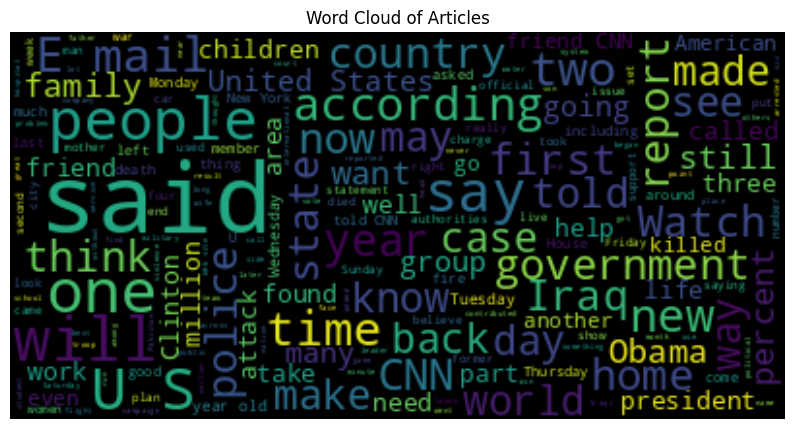

In [6]:
text = ' '.join(train_data['article'][:1000])
wordcloud = WordCloud(max_font_size=50).generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Articles")
plt.show()


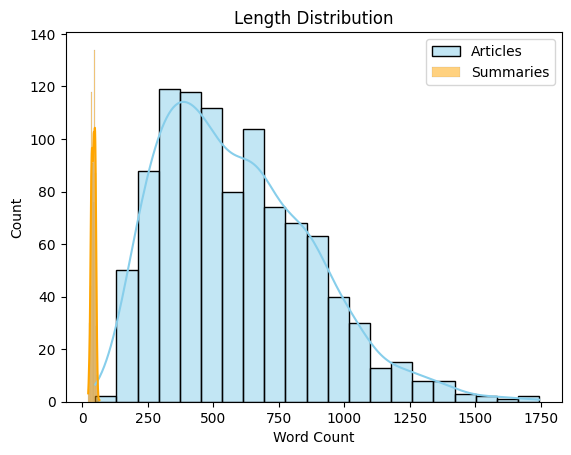

In [7]:
# Length distribution
article_lengths = [len(a.split()) for a in train_data['article'][:1000]]
summary_lengths = [len(s.split()) for s in train_data['highlights'][:1000]]
sns.histplot(article_lengths, kde=True, color="skyblue", label="Articles")
sns.histplot(summary_lengths, kde=True, color="orange", label="Summaries")
plt.legend()
plt.title("Length Distribution")
plt.xlabel("Word Count")
plt.show()


In [8]:
# Top Words
summary_words = Counter()
for s in train_data['highlights'][:1000]:
    summary_words.update(s.lower().split())

print("Top 10 common words in summaries:")
for word, freq in summary_words.most_common(10):
    print(f"{word}: {freq}")

Top 10 common words in summaries:
.: 3340
to: 1067
in: 1040
the: 950
of: 929
a: 503
says: 450
and: 429
for: 381
on: 345


In [9]:
# Named Entities
doc = nlp(train_data[0]['article'])
entities = [(ent.text, ent.label_) for ent in doc.ents]
print("Sample Named Entities:", entities)


Sample Named Entities: [('LONDON', 'GPE'), ('England', 'GPE'), ('Reuters', 'ORG'), ('Harry Potter', 'PERSON'), ('Daniel Radcliffe', 'PERSON'), ('£20 million', 'MONEY'), ('$41.1 million', 'MONEY'), ('18', 'CARDINAL'), ('Monday', 'DATE'), ('Daniel Radcliffe', 'PERSON'), ('Harry Potter', 'PERSON'), ('Harry Potter', 'PERSON'), ('the Order of the Phoenix', 'PERSON'), ('18', 'DATE'), ('Australian', 'NORP'), ('earlier this month', 'DATE'), ('about 10 pounds', 'QUANTITY'), ('18', 'DATE'), ('Radcliffe', 'PERSON'), ('Hostel: Part II', 'WORK_OF_ART'), ('six', 'CARDINAL'), ('one', 'CARDINAL'), ('UK', 'GPE'), ('Radcliffe', 'PERSON'), ('first', 'ORDINAL'), ('five', 'CARDINAL'), ('last month', 'DATE'), ('Harry Potter', 'PERSON'), ('the Order of the Phoenix', 'PERSON'), ('Atlantic', 'LOC'), ('two', 'CARDINAL'), ('Potter', 'PERSON'), ('Potter', 'PERSON'), ('Londoner', 'PERSON'), ('My Boy Jack', 'WORK_OF_ART'), ('Rudyard Kipling', 'PERSON'), ('later this year', 'DATE'), ('December Boys', 'WORK_OF_ART'),

## Data Preprocessing


In [10]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-z0-9\s.,;!?\'\"]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [11]:
# Rare Word Handling
all_words = []
for article in train_data['article'][:3000]:
    all_words.extend(clean_text(article).split())

word_freq = Counter(all_words)
rare_words = set([w for w, c in word_freq.items() if c < 5])

def replace_rare_words(text):
    return ' '.join([token if token not in rare_words else '<unk>' for token in text.split()])


## Model Development

In [32]:
# Tokenizer and Model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn", attn_implementation='eager')

def preprocess(examples):
    articles = [replace_rare_words(clean_text(a)) for a in examples["article"]]
    summaries = [replace_rare_words(clean_text(s)) for s in examples["highlights"]]
    inputs = tokenizer(articles, max_length=512, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(summaries, max_length=128, truncation=True, padding="max_length")
    inputs["labels"] = labels["input_ids"]
    return inputs

In [13]:
tokenized_train = train_data.select(range(500)).map(preprocess, batched=True, remove_columns=["article", "highlights", "id"])

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    num_train_epochs=1,
    fp16=True,
    logging_steps=100,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model)
)

trainer.train()

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/tmp/ipython-input-13-698495635.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
100,2.092700
200,0.856800
300,0.861000
400,0.854900
500,0.853800


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=500, training_loss=1.103847396850586, metrics={'train_runtime': 186.6522, 'train_samples_per_second': 2.679, 'train_steps_per_second': 2.679, 'total_flos': 541776150528000.0, 'train_loss': 1.103847396850586, 'epoch': 1.0})

## Evaluation & Comparison


In [14]:
rouge = evaluate.load("rouge")

def textrank_summary(text, count=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summary = TextRankSummarizer()(parser.document, count)
    return " ".join(str(s) for s in summary)



In [19]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [23]:
# Generate summaries and evaluate on first 5 samples

generated_summaries = []
reference_summaries = []

for i in range(5):
    inputs = tokenizer(train_data[i]["article"], return_tensors="pt", truncation=True, max_length=512).to(model.device)
    output_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4, early_stopping=True)
    gen = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    ref = train_data[i]["highlights"]
    textrank = textrank_summary(train_data[i]["article"])

    generated_summaries.append(gen)
    reference_summaries.append(ref)

    print(f"\n ARTICLE {i+1}")
    print("=> Predicted Summary:\n", textwrap.fill(gen, width=100))
    print("=> Actual Summary   :\n", textwrap.fill(ref, width=100))
    print("=> TextRank Summary :\n", textwrap.fill(textrank, width=100))




 ARTICLE 1
=> Predicted Summary:
 Harry Potter star Daniel Radcliffe turns 18 on Monday . He has a reported fortune of $41.1 million .
Radcliffe says he has no plans to fritter his money away . The actor says he will have a "some sort
of party" in honor of his birthday .
=> Actual Summary   :
 Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday . Young actor says he has
no plans to fritter his cash away . Radcliffe's earnings from first five Potter films have been held
in trust fund .
=> TextRank Summary :
 Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the
disappointment of gossip columnists around the world, the young actor says he has no plans to
fritter his cash away on fast cars, drink and celebrity parties. At 18, Radcliffe will be able to
gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six
places below his number one movie on the UK box office chart. His latest outing as the 

The BART-generated (Predicted) summaries are concise, often closer to actual summary.but,

*   Sometimes miss minor details (e.g., date, place names)


*   Occasionally over-summarize, skipping context or nuance



In [24]:
rouge_scores = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print("\n ROUGE Scores:", rouge_scores)


 ROUGE Scores: {'rouge1': np.float64(0.4171362313830553), 'rouge2': np.float64(0.18499656897305808), 'rougeL': np.float64(0.27629994526546253), 'rougeLsum': np.float64(0.3535603376256734)}


## Feedback Loop Design


In [26]:
feedback = input("Was the summary helpful? (👍 or 👎): ")
with open("feedback_log.txt", "a") as f:
    f.write(feedback + "\n")
print("Feedback saved.")

Was the summary helpful? (👍 or 👎): 
Feedback saved.


## Explainability

In [36]:
# Explainability: Attention Visualization
# Generate summary
inputs = tokenizer(train_data[0]["article"], return_tensors="pt", max_length=512, truncation=True).to(model.device)

summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4)
summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("\nGenerated Summary:\n", summary_text)

# Manually pass for attention
model.config.attn_implementation = 'eager'

# Get encoder outputs
with torch.no_grad():
    encoder_outputs = model.get_encoder()(inputs["input_ids"])

# Get decoder outputs with attentions
with torch.no_grad():
    outputs = model(
        input_ids=inputs["input_ids"],
        encoder_outputs=encoder_outputs,
        decoder_input_ids=summary_ids,
        output_attentions=True,
        return_dict=True
    )

# Extract attention (last decoder layer, mean over heads)
# Cross-attentions are stored in `cross_attentions` when `decoder_input_ids` are provided
cross_attn = outputs.cross_attentions[-1][0].mean(dim=0).cpu().numpy()





Generated Summary:
 Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund. Details of how he'll mark his landmark birthday are under wraps.


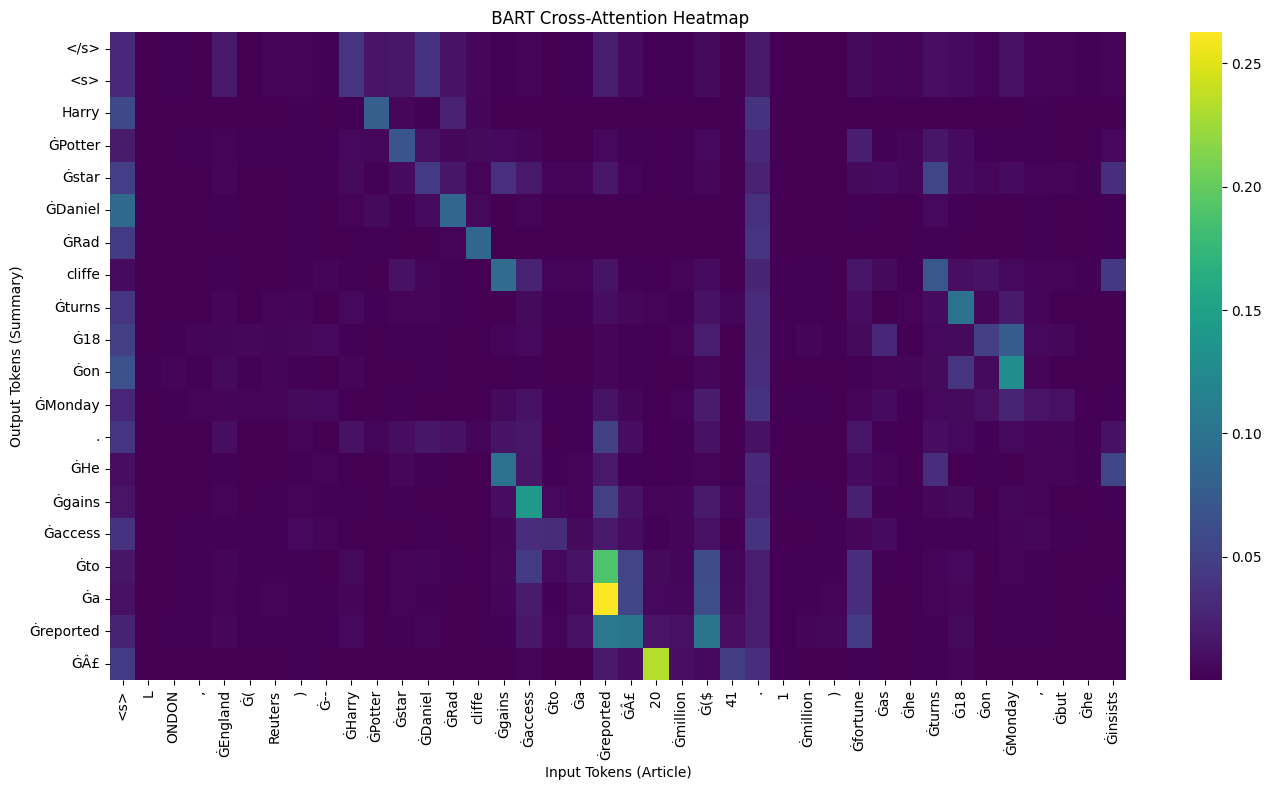

In [37]:
# Limit tokens for readability
max_input_tokens = 40
max_output_tokens = 20

# Step 4: Visualize
plt.figure(figsize=(14, 8))
sns.heatmap(
    cross_attn[:max_output_tokens, :max_input_tokens],
    xticklabels=input_tokens[:max_input_tokens],
    yticklabels=output_tokens[:max_output_tokens],
    cmap="viridis"
)
plt.xlabel("Input Tokens (Article)")
plt.ylabel("Output Tokens (Summary)")
plt.title(" BART Cross-Attention Heatmap")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
